# Color Detection

## load libraries

In [1]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

## load image

In [55]:
# load image from path ../../image_detection/images_test/test/01.png
image = cv2.imread('./test_images/02.png')

## convert image to hsv

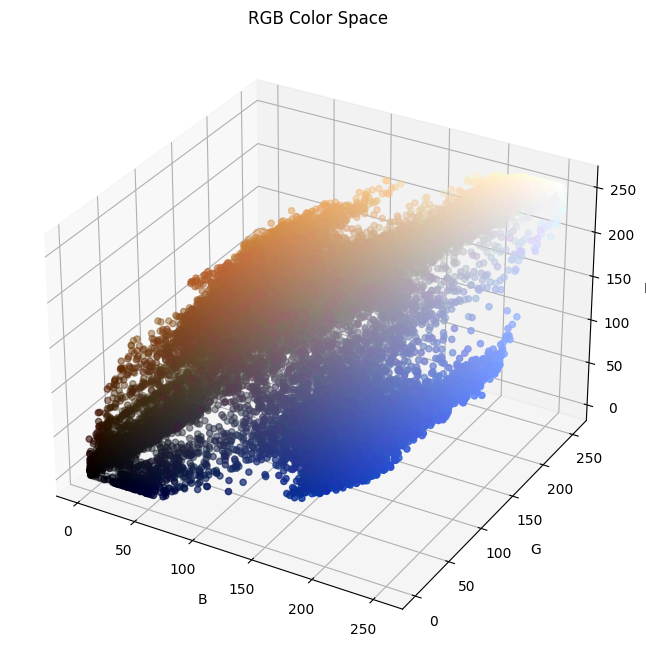

In [56]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Reshape the image to be a list of pixels
pixels = hsv_image.reshape(-1, 3)

pixels_bgr = image.reshape(-1, 3)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pixels_bgr[:, 0], pixels_bgr[:, 1], pixels_bgr[:, 2], c=pixels_bgr[:, [2, 1, 0]] / 255.0, marker='o')
ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('R')
ax.set_title('RGB Color Space')

# Rotate the plot
# ax.view_init(elev=70, azim=40)

plt.show()

## perform PCA

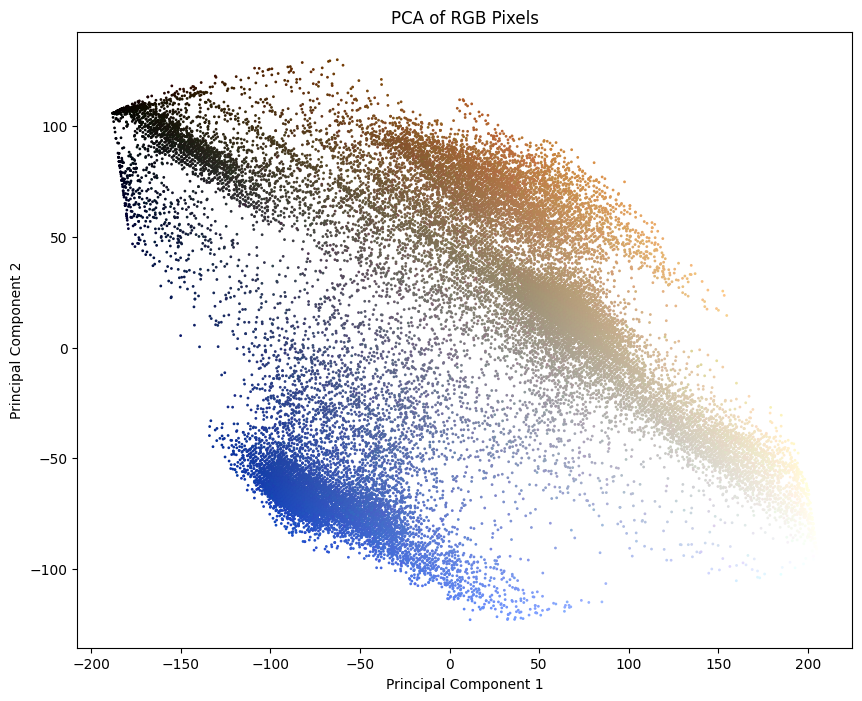

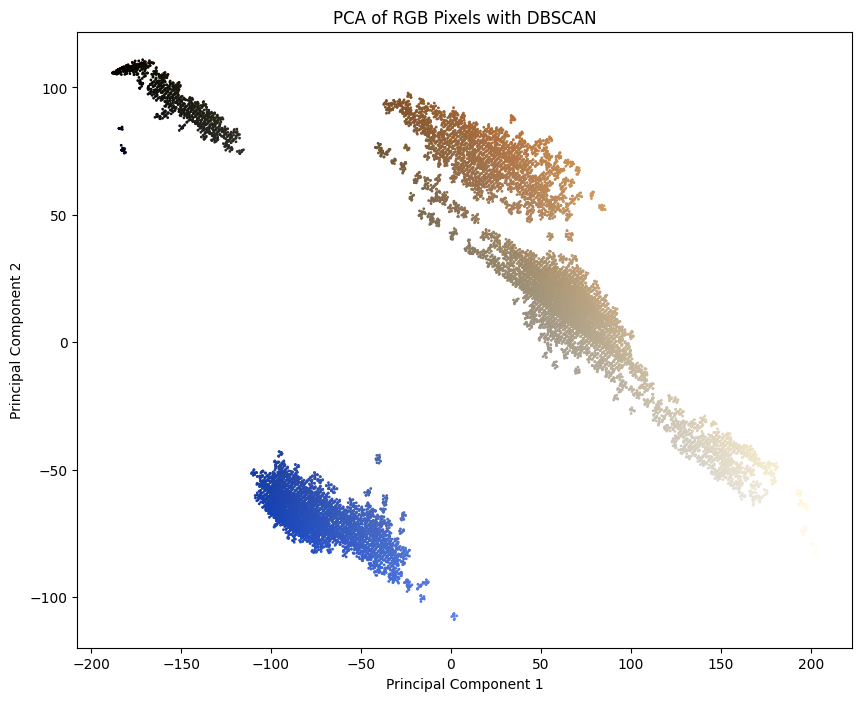

In [57]:
 # Convert BGR to RGB
pixels_rgb = pixels_bgr[:, [2, 1, 0]]

# Perform PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
pixels_2d = pca.fit_transform(pixels_rgb)

# Plot the 2D data
plt.figure(figsize=(10, 8))
plt.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=pixels_rgb / 255.0, marker='o', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RGB Pixels')
plt.show()

# Apply DBSCAN to find dense regions
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan.fit(pixels_2d)

# Get the labels for each point
labels = dbscan.labels_

# Filter out noise points (label == -1)
mask = labels != -1
filtered_pixels_2d = pixels_2d[mask]
filtered_pixels_rgb = pixels_rgb[mask]

# Plot the 2D data with DBSCAN results
plt.figure(figsize=(10, 8))
plt.scatter(filtered_pixels_2d[:, 0], filtered_pixels_2d[:, 1], c=filtered_pixels_rgb / 255.0, marker='o', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RGB Pixels with DBSCAN')
plt.show()

## kmeans

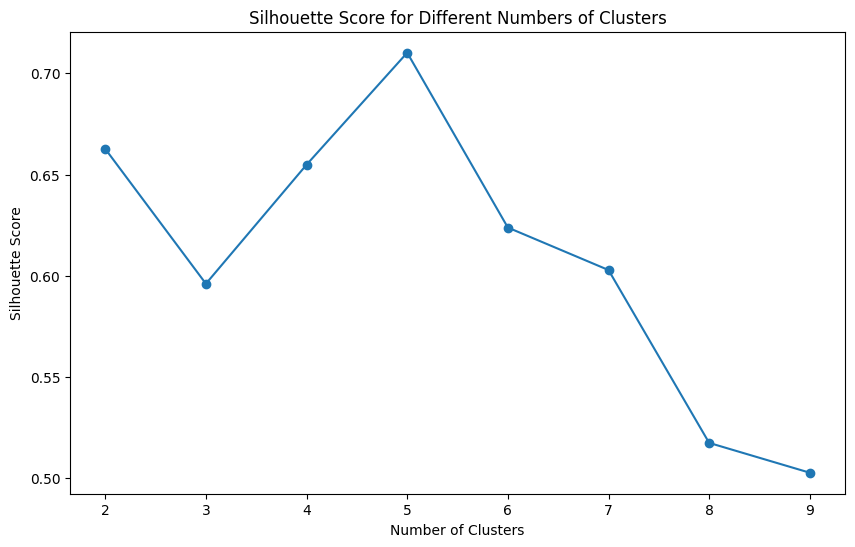

The optimal number of clusters is 5


In [67]:
silhouette_scores = []

top_clusters = 10

# Try different numbers of clusters
for n_clusters in range(2, top_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(filtered_pixels_rgb)
    labels = kmeans.labels_
    
    # Calculate the silhouette score only if there are more than 1 cluster
    if n_clusters > 1:
        silhouette_avg = silhouette_score(filtered_pixels_rgb, labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)  # Silhouette score is not defined for a single cluster

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, top_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# Find the number of clusters with the highest silhouette score
optimal_clusters = np.argmax(silhouette_scores[1:]) + 3  # +2 because index 0 corresponds to 1 cluster
print(f'The optimal number of clusters is {optimal_clusters}')

In [68]:
# Apply K-means clustering to find the main colors
# optimal_clusters = 2  # Number of main colors you want to find
kmeans = KMeans(n_clusters=optimal_clusters)
kmeans.fit(filtered_pixels_rgb)
# kmeans.fit(pixels_bgr)
# kmeans.fit(pixels)

KMeans(n_clusters=5)

## plot the clusters in the 2 dimensional space

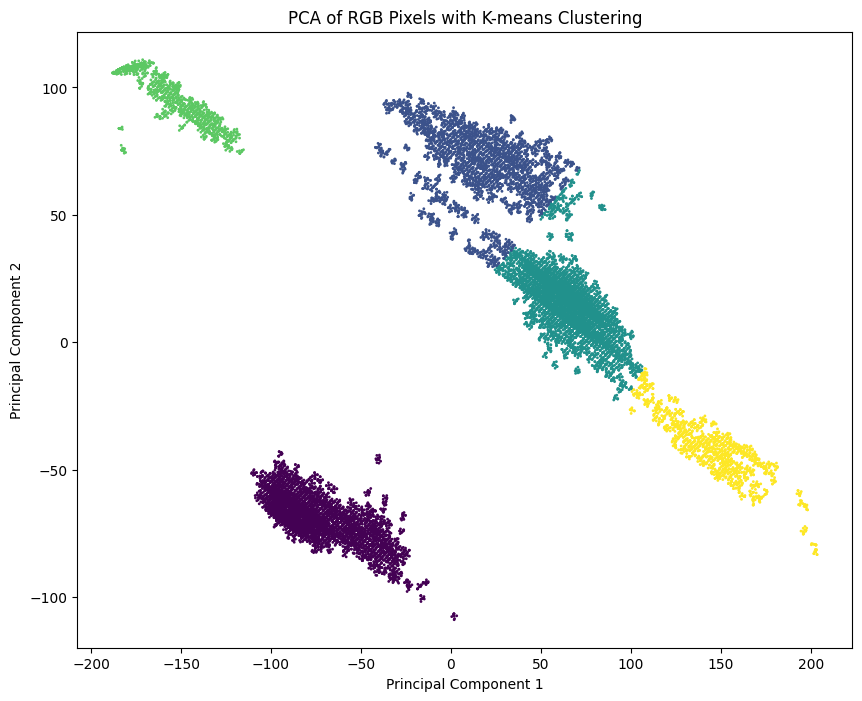

In [69]:
# plot the clusters in the 2 dimensional space
plt.figure(figsize=(10, 8))
plt.scatter(filtered_pixels_2d[:, 0], filtered_pixels_2d[:, 1], c=kmeans.labels_ / optimal_clusters, marker='o', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RGB Pixels with K-means Clustering')
plt.show()

## get colors

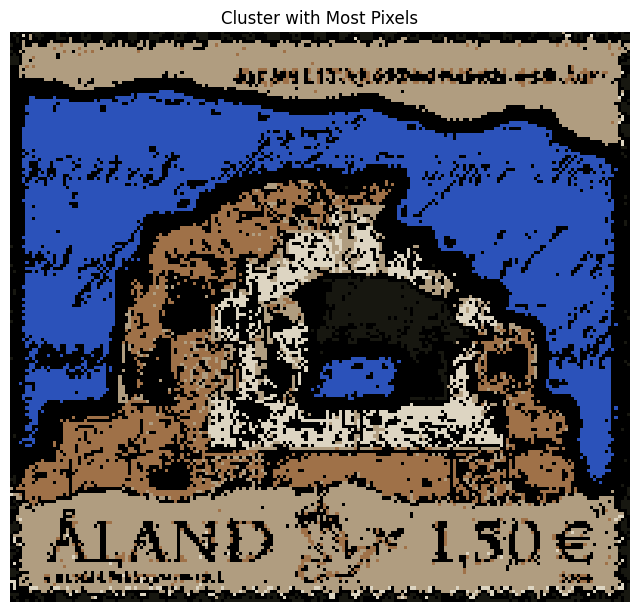

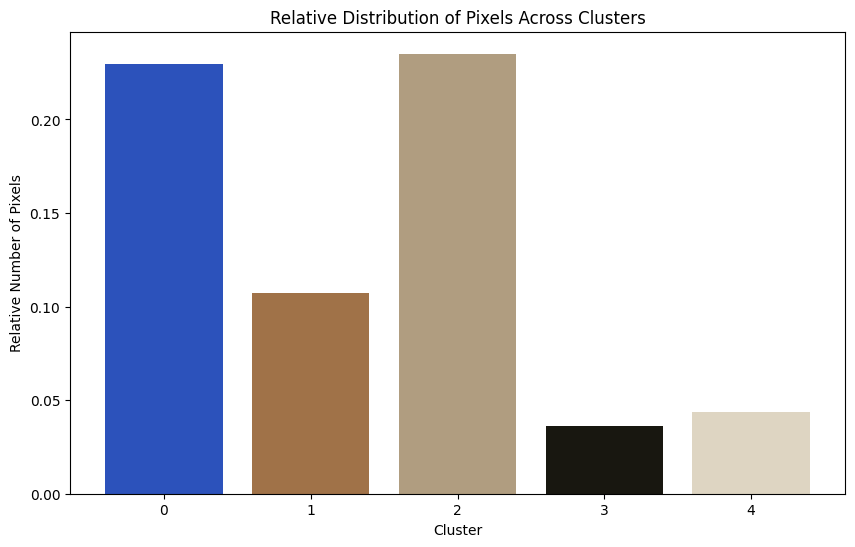

In [70]:
# Get the cluster centers (the main colors)
main_colors = kmeans.cluster_centers_

# Get the labels for each pixel
labels = kmeans.labels_

# Find the cluster with the most pixels
unique, counts = np.unique(labels, return_counts=True)
max_cluster = unique[np.argmax(counts)]

# Filter the pixels belonging to the cluster with the most pixels
max_cluster_pixels = filtered_pixels_rgb[labels == max_cluster]

# Create an image showing only the pixels of the largest cluster
max_cluster_image = np.zeros_like(pixels_rgb)
max_cluster_image[mask] = main_colors[labels]
max_cluster_image = max_cluster_image.reshape(image.shape)

# Plot the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(max_cluster_image.astype(np.uint8))
plt.axis('off')
plt.title('Cluster with Most Pixels')
plt.show()

# Plot the main colors
# plt.figure(figsize=(8, 2))
# for i, color in enumerate(main_colors):
#     plt.subplot(1, num_clusters, i + 1)
#     plt.imshow([[color / 255.0]])
#     plt.axis('off')
# plt.suptitle('Main Colors')
# plt.show()

# # Print the main colors in RGB
# print("Main colors in RGB:")
# print(main_colors)

# print("main color:")
# print(main_colors[max_cluster])

# Create a distribution plot of how many pixels were assigned to each color
# Calculate the total number of pixels in the original image
total_pixels = pixels_rgb.shape[0]

# Calculate the relative counts
relative_counts = counts / total_pixels

# Create a distribution plot of how many pixels were assigned to each color (relative to the original amount of pixels)
plt.figure(figsize=(10, 6))
plt.bar(range(optimal_clusters), relative_counts, color=main_colors / 255.0)
plt.xlabel('Cluster')
plt.ylabel('Relative Number of Pixels')
plt.title('Relative Distribution of Pixels Across Clusters')
plt.show()

# Other testing

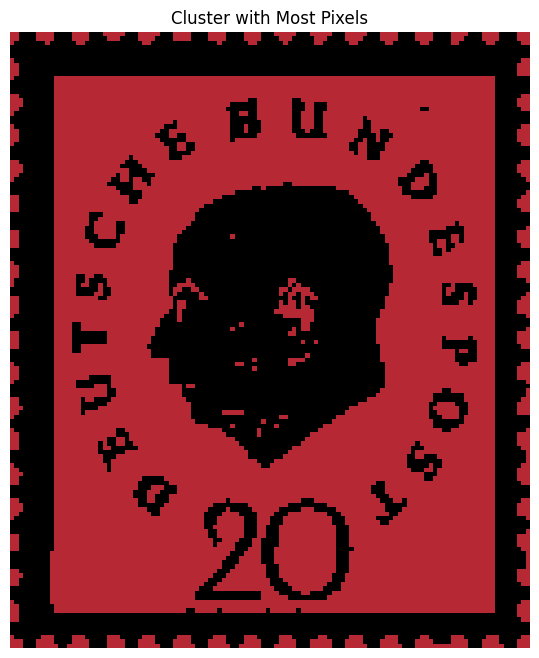

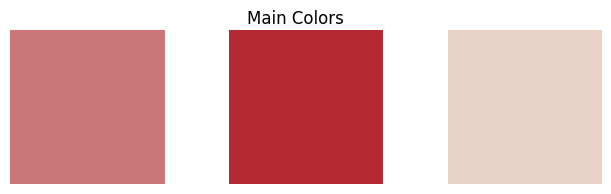

Main colors in BGR:
[[118.79416101 118.51843114 203.19994102]
 [ 52.54666105  40.63745523 182.14324837]
 [198.84401651 211.2176066  232.64539202]]
Main colors in RGB:
[[203.19994102 118.51843114 118.79416101]
 [182.14324837  40.63745523  52.54666105]
 [232.64539202 211.2176066  198.84401651]]


In [99]:
# Get the cluster centers (the main colors)
main_colors = kmeans.cluster_centers_

# Get the labels for each pixel
labels = kmeans.labels_

# Convert the main colors from BGR to RGB for visualization
main_colors_rgb = main_colors[:, [2, 1, 0]]

# Find the cluster with the most pixels
unique, counts = np.unique(labels, return_counts=True)
max_cluster = unique[np.argmax(counts)]

# Filter the pixels belonging to the cluster with the most pixels
max_cluster_pixels = pixels[labels == max_cluster]

# Create an image showing only the pixels of the largest cluster
max_cluster_image = np.zeros_like(pixels)
max_cluster_image[labels == max_cluster] = main_colors_rgb[max_cluster]
max_cluster_image = max_cluster_image.reshape(image.shape)


# Plot the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(max_cluster_image.astype(np.uint8))
plt.axis('off')
plt.title('Cluster with Most Pixels')
plt.show()

# Plot the main colors
plt.figure(figsize=(8, 2))
for i, color in enumerate(main_colors_rgb):
    plt.subplot(1, num_clusters, i + 1)
    plt.imshow([[color / 255.0]])
    plt.axis('off')
plt.suptitle('Main Colors')
plt.show()

# Print the main colors in BGR and RGB
print("Main colors in BGR:")
print(main_colors)
print("Main colors in RGB:")
print(main_colors_rgb)

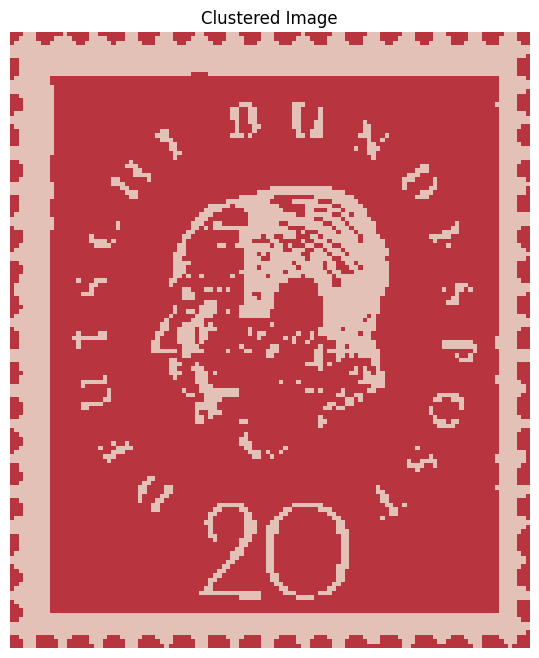

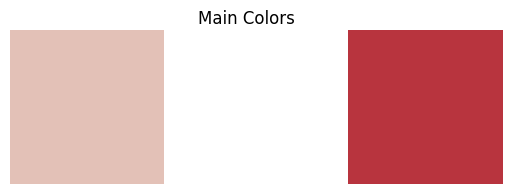

Main colors in BGR:
[[183.56074575 193.46117599 227.64904733]
 [ 62.59532606  52.5131025  184.96692156]]
Main colors in RGB:
[[227.64904733 193.46117599 183.56074575]
 [184.96692156  52.5131025   62.59532606]]


In [86]:
# Get the cluster centers (the main colors)
main_colors = kmeans.cluster_centers_

# Get the labels for each pixel
labels = kmeans.labels_

# Convert the main colors from BGR to RGB for visualization
main_colors_rgb = main_colors[:, [2, 1, 0]]

# Create an image showing the clustered pixels
clustered_image = main_colors_rgb[labels].reshape(image.shape)

# Plot the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(clustered_image.astype(np.uint8))
plt.axis('off')
plt.title('Clustered Image')
plt.show()

# Plot the main colors
plt.figure(figsize=(8, 2))
for i, color in enumerate(main_colors_rgb):
    plt.subplot(1, num_clusters, i + 1)
    plt.imshow([[color / 255.0]])
    plt.axis('off')
plt.suptitle('Main Colors')
plt.show()

# Print the main colors in BGR and RGB
print("Main colors in BGR:")
print(main_colors)
print("Main colors in RGB:")
print(main_colors_rgb)